In [ ]:
!pip install monai
!pip install torchmetrics
!pip install segmentation_models_pytorch

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/dl final\ project\ 3
root_dir = "/content/drive/MyDrive/dl final project 3"

Mounted at /content/drive
/content/drive/My Drive/dl final project 3


In [4]:
import os
import pickle
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from custom_model import CustomModel

warnings.filterwarnings("ignore")

### Load preprocessed data

In [5]:
# make sure those files exist before running this cell
with open(os.path.join(root_dir, "kfold_splits.pkl"), "rb") as f:
    folds = pickle.load(f)
with open(os.path.join(root_dir, "test_set.pkl"), "rb") as f:
    test_set = pickle.load(f)

### Define training function

In [6]:
def get_model(model_type, device, attention_gate_flag=False):
    if model_type == "resnet":
        # Create the UNet model with the specified backbone
        model = smp.Unet(
            encoder_name="resnet34",
            in_channels=3,
            classes=1,
            activation="sigmoid",
            encoder_weights=None,
        ).to(device)
    elif model_type == "unet":
        model = torch.hub.load(
            "mateuszbuda/brain-segmentation-pytorch",
            "unet",
            in_channels=3,
            out_channels=1,
            init_features=32,
            pretrained=False,
        ).to(device)
    elif model_type == "segformer":
        config = SegformerConfig(num_labels=1)
        model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            num_labels=1,
            ignore_mismatched_sizes=True,
        ).to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels=[64, 128, 256, 512],
            scale=[4, 2, 2, 2],
            num_blocks=[2, 2, 2, 2],
            num_heads=[2, 4, 8, 16],
            mlp_hidden=[256, 512, 1024, 2048],
            dropout=0.2,  # change to dropout rate=0.2
            decoder_hidden=256,
            attention=attention_gate_flag,  # whether to use attention gate
        ).to(device)

    return model

### Training

In [7]:
gpu = "cuda"
gpu = "cpu"
loss = "Jaccard"

In [8]:
if gpu == "cuda":
    device = torch.device("cuda:0")
elif gpu == "cpu":
    device = torch.device("cpu")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [9]:
loss_function, metric

(JaccardLoss(), BinaryJaccardIndex())

In [10]:
set_determinism(0)

Load Model and Visualize Attention

In [30]:
model_type = "custom"
out_dir = os.path.join(root_dir, model_type)

test_loader = DataLoader(test_set, batch_size=8, num_workers=4)

model = get_model(model_type, device, attention_gate_flag=True)


# for saved_model in ["model_epoch_1.pth", "model_epoch_30.pth", "model_epoch_50.pth"]:
for saved_model in [
    "model_epoch_70.pth",
    "model_epoch_90.pth",
    "best_metric_model.pth",
]:

    if gpu == "cuda":
        model.load_state_dict(
            torch.load(os.path.join(root_dir, model_type, saved_model))
        )
    elif gpu == "cpu":
        model.load_state_dict(
            torch.load(
                os.path.join(root_dir, model_type, saved_model),
                map_location=torch.device("cpu"),
            )
        )
        print("model loaded")

    model.eval()

    # Attach the hook to the first self-attention block of the first transformer in the first encoder layer

    for layer in range(3):
        for block in range(2):

            # Function to attach a hook and capture attention weights
            def attention_hook(module, input, output):
                global attention_weights
                # output is a tuple of (output, attn_weights), where attn_weights is what we need
                attention_weights = output[
                    1
                ].detach()  # Detach to avoid any gradient computation

            handle = (
                model.encoder.layers[layer]["transformers"]
                .blocks[block]["self-attention"]
                .attention.register_forward_hook(attention_hook)
            )

            with torch.no_grad():
                for i, test_data in enumerate(test_loader):
                    # if i != 103:
                    if i not in [37, 85, 103, 105]:
                        continue

                    img_index = 1

                    # run the model to get attentions
                    test_outputs = model(test_data["image"].to(device))
                    test_labels = test_data["label"].to(device)

                    attention_map = attention_weights[img_index][
                        0
                    ]  # First head's attention weights of the first example
                    attention_map = attention_map.cpu()  # Move the attention map to CPU
                    # Reshape the attention map to its square form if it's flat (assuming it's a square matrix)
                    side_length = int(attention_map.shape[0] ** 0.5)
                    attention_map = attention_map.view(side_length, side_length)
                    attention_map = (attention_map - attention_map.min()) / (
                        attention_map.max() - attention_map.min()
                    )

                    plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
                    plt.suptitle(
                        f"TestImage_{i} Attention: Layer {layer}, Block {block}, Head: 0_{saved_model}.png"
                    )

                    # Plot original image
                    img = test_data["image"][img_index].cpu().numpy().transpose(1, 2, 0)
                    img = (img - img.min()) / (
                        img.max() - img.min()
                    )  # Normalize image for displaying
                    plt.subplot(1, 4, 1)
                    plt.imshow(img)
                    plt.title("Input Image")
                    plt.axis("off")

                    # Plot labeled image
                    label_img = test_data["label"][img_index].cpu().numpy().squeeze()
                    plt.subplot(1, 4, 2)
                    plt.imshow(label_img, cmap="gray")
                    plt.title("Label")
                    plt.axis("off")

                    # Plot attention image
                    plt.subplot(1, 4, 3)
                    attention_map_np = attention_map.numpy()
                    attention_map_np = cv2.resize(attention_map.numpy(), (128, 128))
                    plt.imshow(attention_map_np, cmap="inferno")
                    plt.title("Attention Map")
                    plt.axis("off")
                    # plt.colorbar()

                    # Plot attention image overlayed on original image
                    plt.subplot(1, 4, 4)
                    input_image = img.copy()
                    input_image = input_image[:, :, 0]

                    # select a colormap from matplotlib
                    colormap = plt.get_cmap("inferno")

                    # Create overlay image from attention_map
                    attention_map_overlay = attention_map_np.copy()
                    attention_map_overlay = (
                        colormap(attention_map_overlay) * 255
                    ).astype(np.uint8)
                    attention_map_overlay = attention_map_overlay[:, :, :3]

                    # Convert input image to three channels (to match attention_map_overlay dimensions)
                    # Also convert scale to 0-255
                    input_image_bgr = (
                        cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR) * 255
                    )

                    # Combine both original image and overlay image
                    overlay_weight = 0.5
                    final_image = (
                        attention_map_overlay * overlay_weight
                        + input_image_bgr * (1 - overlay_weight)
                    )
                    final_image = final_image.astype(np.uint8)

                    # Display images
                    plt.imshow(final_image)
                    plt.axis("off")
                    plt.title("Overlaid Attention")

                    file_name = f"TestImage_{i} Attention: Layer {layer}, Block {block}, Head: 0_{saved_model}.png"
                    plt.savefig(os.path.join(root_dir, model_type, "images", file_name))

                    plt.show()

                    if i == 105:
                        break

    plt.show()
    handle.remove()  # Clean up the hook after use to prevent memory leak

Output hidden; open in https://colab.research.google.com to view.

['/content/drive/MyDrive/dl final project 3/custom/images/TestImage_37 Attention: Layer 0, Block 0, Head: 0_model_epoch_1.pth.png', '/content/drive/MyDrive/dl final project 3/custom/images/TestImage_37 Attention: Layer 0, Block 0, Head: 0_model_epoch_30.pth.png', '/content/drive/MyDrive/dl final project 3/custom/images/TestImage_37 Attention: Layer 0, Block 0, Head: 0_model_epoch_50.pth.png', '/content/drive/MyDrive/dl final project 3/custom/images/TestImage_37 Attention: Layer 0, Block 0, Head: 0_model_epoch_70.pth.png', '/content/drive/MyDrive/dl final project 3/custom/images/TestImage_37 Attention: Layer 0, Block 0, Head: 0_model_epoch_90.pth.png', '/content/drive/MyDrive/dl final project 3/custom/images/TestImage_37 Attention: Layer 0, Block 0, Head: 0_best_metric_model.pth.png']


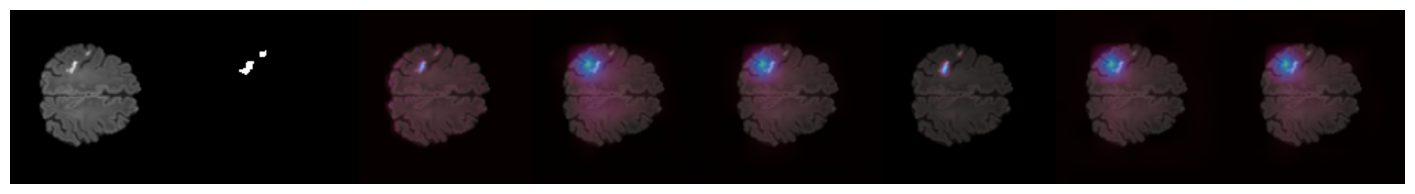

In [72]:
model_type = "custom"

import re

# Images are already saved in this folder.
# Reload the images and format them to be presentable in the paper
imgs_dir = os.path.join(root_dir, model_type, "images")

# We saved the first images from test batch 37, 85, 103, 105
img_ids = [37, 85, 103, 105]
layers = [0, 1, 2]
blocks = [0, 1]

for img_id in img_ids:
    # Get only images in the images folder that contain img_id
    # There should be a better way to do this, but I will leave it as is for now
    img_id_files = [
        os.path.join(imgs_dir, f) for f in os.listdir(imgs_dir) if str(img_id) in f
    ]

    for layer in layers:
        # Keep only images from layer
        img_layer_files = [
            img_file
            for img_file in img_id_files
            if re.search(f"Layer {str(layer)}", img_file)
        ]

        for block in blocks:
            # Get only images from layer
            img_files = [
                img_file
                for img_file in img_layer_files
                if re.search(f"Block {str(block)}", img_file)
            ]

            # sort them by epoch
            # Note: there should be a better way to sort them by epoch, but I think this is good enough for now...
            img_files = sorted(img_files)

            # the first in the list will be "best_metric_model". move this to the end
            best_model = img_files[0]
            img_files = img_files[1:]
            img_files.append(best_model)
            print(img_files)

            # Create an empty np.array (white background) to store the final combined img
            combined_img = np.ones((303, 303 * 8, 3)) * 255

            # Put the original image and labeled image in the first two slots of the combined_img
            img = cv2.imread(img_files[0])
            original_img = img[151:454, 225:528, :]
            label_img = img[151:454, 589:892, :]

            combined_img[0:303, 0:303, :] = img[151:454, 225:528, :]
            combined_img[0:303, 303:606, :] = img[151:454, 589:892, :]

            # Read each image file and place the overlay image in the next slots of the combined_img
            for i, img_file in enumerate(img_files):
                img = cv2.imread(img_file)
                overlay_img = img[151:454, 1317:1620, :]
                start_idx = 303 * (i + 2)
                end_idx = start_idx + 303
                combined_img[0:303, start_idx:end_idx, :] = img[151:454, 1317:1620, :]

            # Display the combined image
            plt.figure(figsize=(18, 6))
            plt.axis("off")

            combined_img = combined_img.astype(np.uint8)

            plt.imshow(combined_img)
            file_name = f"TestImage_{img_id} Attention: Layer {layer}, Block {block}, Head: 0.png"
            plt.savefig(
                os.path.join(root_dir, model_type, "images combined", file_name)
            )
            plt.show()